# 颜色和着色器

对于刚接触图形学的人来说，第一个想要了解的问题，图形学研究的是什么？简要的回答是，图形学研究渲染器中的理论，算法和工程架构。所谓的渲染器不过是一个简单的程序，输入一个描述 3D 场景的场景文件，输出这个场景所对应的一张图片。

大多数人对于图片的概念，不过是电脑上的 JPG 和 PNG 文件。如果使用 Photoshop 之类的软件打开任何一张图片，就会发现图片由一组带颜色的小格子构成，每一个格子称之为像素。对于每一个像素来言，一般来说由三种颜色构成，或者称为三个通道，即红绿蓝通道。每一个通道的取值均为`[0,1]`。对于一些半透明的图片来说，还会引入第四个通道，即透明通道。同样透明通道的的取值范围也是`[0,1]`。

如果一个像素的颜色为`(1,0,0,1)`，像素的四个通道一般情况以`RGBA`的顺序排列，那么很显然这个像素为红色。同样的，如果是`(1,1,0,1)`，那么该像素呈现红色和绿色的混合颜色黄色。

对于每一个像素来说，由于`[0,1]`是一个浮点数，如果我们单纯使用单精度浮点类型`float`进行存储，对于一个包含 RGBA 四通道的像素来说，其大小为 128 个bit，即 16 个 byte。对于一张 1920x1080 分辨率的图片来说，这需要 33177600 个byte，相当于 32MB 的大小。事实上，人眼分辨颜色的能力是有限的，如果我们仅仅使用 8 个 bit 来表示一个通道，那么对于每个通道我们将会获得 256 种颜色。红色，绿色，蓝色的混合可以得到 256x256x256，大约一千六百万种颜色。8 bit 相对 32 bit，每个像素仅仅需要 4 个 byte 即可存储，通过一些合适的压缩算法，我们就能将一张 1920x1080 分辨率的图片合理压缩到 2 \~ 3MB 的大小。

因此，绝大部分的图片和颜色都采用 8 bit 的方式来存储。由于 8 bit 刚好可以用`[0,255]`区间的整数或者是两个 16 进制数表示，很多程序，比如 HTML，就会使用 16 进制颜色编码来，例如`#2980b9ff`，来表示颜色。在 Python 中，我们可以使用`(r,g,b,a)`来表示一个颜色，其中每一位的取值范围为`[0,255]`。

## 第一个实验：Python 生成单颜色图片

有了对图片和像素的基本了解，我们不妨在 Python 做一个小实验来生成一张只有颜色的图片。

既然要生成图片，首先我们要考虑图片的格式。我们使用 Python 中的图像处理模块 Pillow 来创建和修改图片。我们可以如此简单的定义我们的图片：

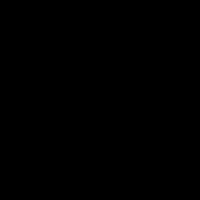

In [1]:
from PIL import Image

w, h = 200, 200
image = Image.new('RGBA', (w, h), 'black')
display(image)

上述语句生成了简单的黑色背景图片，现在我们将其转换成红色。

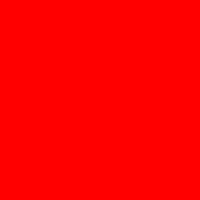

In [2]:
for x in range(0, w):
  for y in range(0, h):
    image.putpixel((x,y), (255,0,0, 255))

display(image)

接下来，我们将在这个基础上，做一些简单的调整，让我们输出的图片更加的漂亮。

## 第二个实验：屏幕空间坐标和着色器

首先，我们再将生成颜色的代码整理成一个函数，以便我们更好的控制颜色的生成过程。该函数传入两个参数，分别是`u`和`v`。`uv`的取值范围为`[0,1]`，图片的左上角为`(0,0)`，图片的右下角为`(1,1)`。

In [3]:
def pixel_color(u: float, v: float):
  return (int(u * 255), int(v * 255), 0, 255)

我们将此着色函数重新应用到我们的绘制过程中：

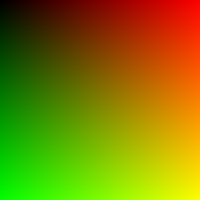

In [4]:
w, h = 200, 200
image = Image.new('RGBA', (w, h), 'black')

for x in range(0, w):
  for y in range(0, h):
    image.putpixel((x,y), pixel_color(x/w, y/h))

display(image)

值得注意的是`pixel_color`函数，它仅仅绘制了一个像素的颜色，而不关心周围像素的绘制情况。我们可以很好的利用并行处理的方式来对每一个像素并行计算颜色并绘制。



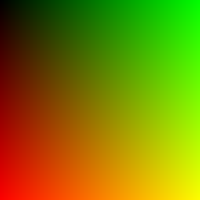

In [5]:
import multiprocessing

w, h = 200, 200
image = Image.new('RGBA', (w, h), 'black')

def pixel_color(uv):
  return (int(uv[0] * 255), int(uv[1] * 255), 0, 255)

coords = [(i//h/w, i%h/h) for i in range(w * h)]
with multiprocessing.Pool() as pool:
  pixels = pool.map(pixel_color, coords)
  image.putdata(pixels)

display(image)

我们这里利用`multiprocessing`库创建多线程任务，并行绘制了同一张图片。`pixel_color`我们称之为像素着色器，在 GPU 上，正是借助了 GPU 并行计算的能力，成千上万的像素着色器在同步执行，这也是 GPU 能快速绘制图片的原因。

## 像素着色器的魔法

虽然我们的程序很短，实际上我们已经实现了一个完整的像素着色的过程。仅仅依赖于像素着色器，和 GPU 的并行计算的优势，我们就可以创建无数优美的图画。

[ShaderToy](https://www.shadertoy.com/) 是一家专注于发布和分享像素着色器的平台。无数的艺术家、程序员在上面创建了各种魔法般的图案。

![Shadertoy](assets/01-color/shadertoy.png)

图片来自 [https://www.shadertoy.com/view/ltfXzj](https://www.shadertoy.com/view/ltfXzj)

## 小结

本章节中，我们介绍了图片和颜色的格式，并且通过 C++ 生成了简单的图片。在我们正式进入到渲染管线之前，我们都会通过图片的形式来演示光栅化的过程。

我们还引出了屏幕空间的概念，在本章节的屏幕坐标系中，是一个仅有二维坐标，并且取值范围在`[0,1]`的空间。

紧接着，我们讨论了着色过程和像素着色器。像素着色器真正揭示了 GPU 的并行原理。因为每个像素着色器互不依赖，因此 GPU 才可以同时计算每个像素的颜色。

整个图形学研究的内容就是如何快速地，更逼真地对场景完成整个着色过程。下一章节，我们将从最简单的几何图形出发，为我们的渲染器增加图元渲染的能力。
